## **Installing Libraries:**

In [ ]:
# !pip install pandas
# !pip install openpyxl
# !pip install seaborn
# !pip install imblearn

In [163]:
import pandas as pd
import numpy as np
import re
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier


## **Loading the address dataset:**

In [3]:
# Load the address dataset
file_path = './static/address.xlsx'
address_df = pd.read_excel(file_path)

# Display the first few rows
address_df.head()


,address,city,pincode,state,index
0,Jatpura ward no.6 near manwatkar hospital chan...,Chandrapur,442402,Maharashtra,2
1,road dera baba nanak village dhilwan,Gurdaspur,143605,Punjab,3
2,Sanjay D gohil una anand vade veravalrod una ...,Una,362756,Gujarat,6
3,Mekliganj ward no 07,Cooch Behar,735304,West Bengal,7
4,"Mohan Nagar, Dhankawadi",Pune,411043,Maharashtra,10


In [45]:
# Shape of address dataset
address_df.shape

(4467, 5)

In [92]:
# Display the last few rows
address_df.tail()

,address,city,pincode,state,index
4462,304 3rd floor sai avenue,Surendra Nagar,363310,Gujarat,10368
4463,3/314ammannagar,Salem,636101,Tamil Nadu,10369
4464,A 25 Cozihom 251 Pali Hill,Mumbai,400050,Maharashtra,10373
4465,Birami pali district,Pali,306115,Rajasthan,10378
4466,Birami pali district,Pali,306115,Rajasthan,10379


In [88]:
# address_df info
address_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467 entries, 0 to 4466
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  4467 non-null   object
 1   city     4467 non-null   object
 2   pincode  4465 non-null   object
 3   state    4467 non-null   object
 4   index    4467 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 174.6+ KB


# **1. Data Cleaning:**

* Identify and handle missing values in the dataset (address, city, state, or pincode).

* Ensure consistent capitalization (e.g., converting all text to lowercase).

* Remove any special characters that may not be useful for classification.


In [93]:
# Check for missing values
address_df.isnull().sum()

address    0
city       0
pincode    2
state      0
index      0
dtype: int64

In [97]:
# normalizing the addresses
def normalize_address(address):
    if not isinstance(address, str):
        address = str(address)  # Convert non-string values to strings

    if pd.isnull(address):
        return ''
    address = address.lower()
    address = re.sub(r'\b(\d+)\b', r'\1', address)  # Normalize street numbers
    address = re.sub(r'[^a-z0-9\s,]', '', address)  # Remove special characters
    address = re.sub(r'\s+', ' ', address)  # Replace multiple spaces with a single space
    address = address.strip()  # Remove leading and trailing spaces

    # Standardize common abbreviations and correct common misspellings
    address = re.sub(r'\bst\b', 'street', address)
    address = re.sub(r'\brd\b', 'road', address)
    address = re.sub(r'\bave\b', 'avenue', address)
    address = re.sub(r'\bblvd\b', 'boulevard', address)
    address = re.sub(r'\bdr\b', 'drive', address)
    address = re.sub(r'\bct\b', 'court', address)
    address = address.lower()  # Convert to lowercase
  
    return address

# Clean the relevant columns
for col in ['address', 'city', 'state']:
    address_df[col] = address_df[col].apply(normalize_address)

address_df['pincode'] = address_df['pincode'].astype(str).str.replace('[^0-9]', '', regex=True).str.strip()

# Handle missing values by replacing them with any placeholder
address_df.fillna('Unknown', inplace=True)

# Display the cleaned dataframe
address_df.head()


,address,city,pincode,state,index
0,jatpura ward no6 near manwatkar hospital chand...,chandrapur,442402,maharashtra,2
1,road dera baba nanak village dhilwan,gurdaspur,143605,punjab,3
2,sanjay d gohil una anand vade veravalrod una g...,una,362756,gujarat,6
3,mekliganj ward no 07,cooch behar,735304,west bengal,7
4,"mohan nagar, dhankawadi",pune,411043,maharashtra,10


In [99]:
# after handling missing values
address_df.isnull().sum()


address    0
city       0
pincode    0
state      0
index      0
dtype: int64

In [100]:
# addresses
address_df['address'].value_counts()

address
khasra nos 205252112, 2522, 20052, 6, 7, 8, 9, 12, 13, 14, 15, 161 and 171     33
shop no 25,karta ram street,modi complex                                       12
house                                                                          10
                                                                                8
palash sales and service ,shop no 1 near punjab national bank main road ,ba     5
                                                                               ..
kund barrier                                                                    1
panchkoshi road pandeypur                                                       1
road no 4 lohegaon pune                                                         1
120500 9                                                                        1
jatpura ward no6 near manwatkar hospital chandrapur                             1
Name: count, Length: 3716, dtype: int64

In [101]:
# cities
address_df['city'].value_counts()

city
bangalore           210
mumbai              198
pune                167
thane               150
hyderabad           125
                   ... 
jalandhar punjab      1
silapathar            1
shahdol               1
kolasib               1
surendra nagar        1
Name: count, Length: 502, dtype: int64

In [102]:
# states
address_df['state'].value_counts()

state
maharashtra                    787
uttar pradesh                  408
karnataka                      368
delhi                          297
gujarat                        287
tamil nadu                     245
telangana                      235
west bengal                    213
haryana                        204
rajasthan                      167
punjab                         157
madhya pradesh                 156
kerala                         128
andhra pradesh                 123
bihar                          113
odisha                         102
chhattisgarh                    80
assam                           80
jharkhand                       60
jammu and kashmir               50
uttarakhand                     46
goa                             22
himachal pradesh                18
chandigarh                      15
meghalaya                       15
pondicherry                     14
sikkim                          13
arunachal pradesh               10
manipur       

In [103]:
# pincodes
address_df['pincode'].value_counts()

pincode
122506    35
122001    22
201301    19
143001    18
492001    18
          ..
251003     1
636115     1
573103     1
735101     1
442402     1
Name: count, Length: 2214, dtype: int64

## **2. Data Enhancement:**

Validating the addresses with the help of **'Google Address Validation API'**.


In [111]:
def validate_address_via_google_api(row, api_key):
    # Extracting address components from each row of dataframe
    address = row['address']
    city = row['city']
    state = row['state']
    pincode = row['pincode']
    country_code = "IN"  # country is India.
    
    # Construct the request payload
    payload = {
        "address": {
            "addressLines": [address],
            "locality": city,
            "administrativeArea": state,
            "postalCode": pincode,
            "regionCode": country_code
        }
    }

    # Send the request to the Google Address Validation API
    url = f"https://addressvalidation.googleapis.com/v1:validateAddress?key={api_key}"
    response = requests.post(url, json=payload)
    
    # Check the status of the response
    if response.status_code == 200:
        validation_result = response.json()
        return validation_result
    else:
        print(f"API request failed with status code {response.status_code}: {response.text}")
        return None


def validate_addresses_in_dataframe(df, api_key):
    # Apply the validate_address_via_google_api function to each row in the DataFrame
    df['validation_result'] = df.apply(lambda row: validate_address_via_google_api(row, api_key), axis=1)
    return df

api_key = "XXXXXXXXXXXXXXXX"

# Apply address validation
validated_df = validate_addresses_in_dataframe(address_df, api_key)


In [ ]:
# Saved Dataframe to CSV file after validating addresses
# validated_df.to_csv('validated_address.csv', index=False)

In [226]:
# loading validated_address csv file to dataframe
# validated_df = pd.read_csv("./validated_address.csv")

validated_df.head()

,address,city,pincode,state,index,validation_result
0,jatpura ward no6 near manwatkar hospital chand...,chandrapur,442402.0,maharashtra,2,{'result': {'verdict': {'inputGranularity': 'O...
1,road dera baba nanak village dhilwan,gurdaspur,143605.0,punjab,3,{'result': {'verdict': {'inputGranularity': 'R...
2,sanjay d gohil una anand vade veravalrod una g...,una,362756.0,gujarat,6,{'result': {'verdict': {'inputGranularity': 'O...
3,mekliganj ward no 07,cooch behar,735304.0,west bengal,7,{'result': {'verdict': {'inputGranularity': 'O...
4,"mohan nagar, dhankawadi",pune,411043.0,maharashtra,10,{'result': {'verdict': {'inputGranularity': 'O...


## **3. Feature Engineering:**
* **Address completeness** (whether all fields are filled). 
* **Address validity** (whether the address exists).


In [228]:
# Function to check for address completeness
def check_completeness(validated_result):
    if pd.isna(validated_result):
        return 'incomplete'
    

    try:
        # Fix common JSON formatting issues
        validated_result = re.sub(r"(?<=\w)'(?=\w)", r"\'", validated_result)  # Handle apostrophes within words correctly
        validated_result = validated_result.replace("'", '"')                  # Replace all single quotes with double quotes
        validated_result = re.sub(r'\bNone\b', 'null', validated_result)       # Replace Python None with JSON null
        validated_result = re.sub(r'\bTrue\b', 'true', validated_result)       # Replace Python True with JSON true
        validated_result = re.sub(r'\bFalse\b', 'false', validated_result)     # Replace Python False with JSON false
        data = json.loads(validated_result)
        
        # Check the number of missing components
        missing_components = data.get('result', {}).get('address', {}).get('missingComponentTypes', [])
        
        # Check the number of confirmed components
        confirmed_components = [
            comp for comp in data.get('result', {}).get('address', {}).get('addressComponents', [])
            if comp.get('confirmationLevel', '') in ['CONFIRMED', 'UNCONFIRMED_BUT_PLAUSIBLE']
        ]
        
        # Determine the completeness of addresses
        if len(confirmed_components) > 4 and len(missing_components) <= 1:
            return 'complete'
        elif len(confirmed_components) > 0:
            return 'partial_complete'
        else:
            return 'incomplete'
    
    except json.JSONDecodeError:
        return 'incomplete'
    except Exception as e:
        print(f"An error occurred: {e}")
        return 'incomplete'
    

# Create new column - address_completeness
validated_df['address_completeness'] = validated_df['validation_result'].apply(check_completeness)


In [229]:
# Function to determine address validity
def check_validity(validated_result):
    if pd.isna(validated_result) or not validated_result.strip():
        return 'False'
    
    try:
        # Fix common JSON formatting issues
        validated_result = re.sub(r"(?<=\w)'(?=\w)", r"\'", validated_result)  # Handle apostrophes within words correctly
        validated_result = validated_result.replace("'", '"')                  # Replace all single quotes with double quotes
        validated_result = re.sub(r'\bNone\b', 'null', validated_result)       # Replace Python None with JSON null
        validated_result = re.sub(r'\bTrue\b', 'true', validated_result)       # Replace Python True with JSON true
        validated_result = re.sub(r'\bFalse\b', 'false', validated_result)     # Replace Python False with JSON false
        data = json.loads(validated_result)

        # Check if the JSON response received from 'google validation API' for the address
        if len(data) > 1:
            return 'True'
        else:
            return 'False'
    except Exception as e:
        return 'False'
    
# Create new column - address_validity
validated_df['address_validity'] = validated_df['validation_result'].apply(check_validity)


In [253]:
validated_df.head(5)

,address,city,pincode,state,index,validation_result,address_completeness,address_validity,address_quality
0,jatpura ward no6 near manwatkar hospital chand...,chandrapur,442402.0,maharashtra,2,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good
1,road dera baba nanak village dhilwan,gurdaspur,143605.0,punjab,3,{'result': {'verdict': {'inputGranularity': 'R...,complete,True,good
2,sanjay d gohil una anand vade veravalrod una g...,una,362756.0,gujarat,6,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good
3,mekliganj ward no 07,cooch behar,735304.0,west bengal,7,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good
4,"mohan nagar, dhankawadi",pune,411043.0,maharashtra,10,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good


In [231]:
# address_completeness 
validated_df['address_completeness'].value_counts()

address_completeness
complete            4367
partial_complete      91
incomplete             9
Name: count, dtype: int64

In [232]:
# address_validity
validated_df['address_validity'].value_counts()

address_validity
True     4458
False       9
Name: count, dtype: int64

**Classifying addresses into good, medium, and bad categories:**
- **Good**: Address is complete, valid.
- **Medium**: Address is partial complete, may have minor validation issues.
- **Bad**: Address is incomplete, invalid.


In [233]:
# Function to classify address quality
def classify_address_quality(row):
    if row['address_completeness'] == 'complete' and row['address_validity'] == 'True':
        return 'good'
    elif row['address_completeness'] == 'partial_complete' and row['address_validity'] == 'True':
        return 'medium'
    else:
        return 'bad'

# Create column - address_quality
validated_df['address_quality'] = validated_df.apply(classify_address_quality, axis=1)


In [234]:
# address_quality
validated_df['address_quality'].value_counts()

address_quality
good      4367
medium      91
bad          9
Name: count, dtype: int64

In [255]:
validated_df.shape

(4467, 9)

In [256]:
validated_df.head()

,address,city,pincode,state,index,validation_result,address_completeness,address_validity,address_quality
0,jatpura ward no6 near manwatkar hospital chand...,chandrapur,442402.0,maharashtra,2,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good
1,road dera baba nanak village dhilwan,gurdaspur,143605.0,punjab,3,{'result': {'verdict': {'inputGranularity': 'R...,complete,True,good
2,sanjay d gohil una anand vade veravalrod una g...,una,362756.0,gujarat,6,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good
3,mekliganj ward no 07,cooch behar,735304.0,west bengal,7,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good
4,"mohan nagar, dhankawadi",pune,411043.0,maharashtra,10,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good


In [257]:
# missing values in validated_df
validated_df.isnull().sum()

address                 8
city                    1
pincode                 2
state                   5
index                   0
validation_result       9
address_completeness    0
address_validity        0
address_quality         0
dtype: int64

In [259]:
# Fill missing 'address' with a placeholder
validated_df['address'].fillna('Unknown Address', inplace=True)

# Fill missing 'city' and 'state' with the most frequent value (mode)
validated_df['city'].fillna(validated_df['city'].mode()[0], inplace=True)
validated_df['state'].fillna(validated_df['state'].mode()[0], inplace=True)

# Fill missing 'pincode' with the median value
validated_df['pincode'].fillna(validated_df['pincode'].median(), inplace=True)

# Handle missing 'validation_result' with a placeholder
validated_df['validation_result'].fillna('{"result": {}}', inplace=True)


In [260]:
# after handled missing values in validated_df
validated_df.isnull().sum()

address                 0
city                    0
pincode                 0
state                   0
index                   0
validation_result       0
address_completeness    0
address_validity        0
address_quality         0
dtype: int64

In [267]:
# Save the enhanced and classified dataset to CSV file
output_file_path = './static/enhanced_and_classified_addresses.csv'
validated_df.to_csv(output_file_path, index=False)

print(f"Processed data saved to {output_file_path}")


Processed data saved to ./enhanced_and_classified_addresses.csv


In [184]:
# loading validated_address csv file to dataframe
validated_df = pd.read_csv("./static/enhanced_and_classified_addresses.csv")


In [185]:
validated_df.isnull().sum()

address                 0
city                    0
pincode                 0
state                   0
index                   0
validation_result       0
address_completeness    0
address_validity        0
address_quality         0
dtype: int64

**Granularity Features:**

**Input Granularity:** From the **validation_result** JSON response of the **Google Validation API**, the **inputGranularity**, **validationGranularity**, and **geocodeGranularity** fields are converted into categorical features. These features indicate the precision of the address and its validation.

In [186]:
def clean_json_string(json_str):
    """Cleaning the JSON string to ensure it's properly formatted."""
    if pd.isna(json_str):
        return None
    try:
        # Handle apostrophes within words correctly
        json_str = re.sub(r"(?<=\w)'(?=\w)", r"\'", json_str)
        # Replace single quotes with double quotes
        json_str = json_str.replace("'", '"')
        # Replace Python None with JSON null
        json_str = re.sub(r'\bNone\b', 'null', json_str)
        # Replace Python True/False with JSON true/false
        json_str = re.sub(r'\bTrue\b', 'true', json_str)
        json_str = re.sub(r'\bFalse\b', 'false', json_str)
        return json_str
    except Exception as e:
        print(f"Error in cleaning JSON: {e}")
        return None

def extract_granularity(json_str):
    """Extracting granularity features from the JSON string."""
    if not json_str:
        return {
            'input_granularity': 'UNKNOWN',
            'validation_granularity': 'UNKNOWN',
            'geocode_granularity': 'UNKNOWN'
        }
    try:
        # Clean the JSON string
        json_str = clean_json_string(json_str)
        if not json_str:
            return {
                'input_granularity': 'UNKNOWN',
                'validation_granularity': 'UNKNOWN',
                'geocode_granularity': 'UNKNOWN'
            }
        # Load the JSON data
        data = json.loads(json_str)
        granularity = data.get('result', {}).get('verdict', {})
        return {
            'input_granularity': granularity.get('inputGranularity', 'UNKNOWN'),
            'validation_granularity': granularity.get('validationGranularity', 'UNKNOWN'),
            'geocode_granularity': granularity.get('geocodeGranularity', 'UNKNOWN')
        }
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}")
        return {
            'input_granularity': 'UNKNOWN',
            'validation_granularity': 'UNKNOWN',
            'geocode_granularity': 'UNKNOWN'
        }
    except Exception as e:
        print(f"Error in extracting granularity: {e}")
        return {
            'input_granularity': 'UNKNOWN',
            'validation_granularity': 'UNKNOWN',
            'geocode_granularity': 'UNKNOWN'
        }

# Apply the granularity feature extraction
granularity_features = validated_df['validation_result'].apply(extract_granularity)
granularity_df = pd.DataFrame(granularity_features.tolist())
validated_df = pd.concat([validated_df, granularity_df], axis=1)


**Geographical Features:**

**Location Accuracy:** We extracted **featureSizeMeters** field from the location object within the geocode field. This field indicates the area size covered by the geocoded address and serves as a proxy for the precision of the geocode.

**Location Bounds:** We extracted differences between the low and high latitude/longitude values in the bounds field. These differences provide insight into the area size, which may correlate with the quality of the address.

In [187]:
def extract_geocode_features(json_str):
    """Extracting geocode-related features from the JSON string."""
    if not json_str:
        return {
            'feature_size': 0,
            'lat_diff': 0,
            'lon_diff': 0
        }
    try:
        # Clean the JSON string
        json_str = clean_json_string(json_str)
        if not json_str:
            return {
                'feature_size': 0,
                'lat_diff': 0,
                'lon_diff': 0
            }
        # Load the JSON data
        data = json.loads(json_str)
        geocode = data.get('result', {}).get('geocode', {})
        bounds = geocode.get('bounds', {})
        low = bounds.get('low', {})
        high = bounds.get('high', {})

        return {
            'feature_size': geocode.get('featureSizeMeters', 0),
            'lat_diff': high.get('latitude', 0) - low.get('latitude', 0),
            'lon_diff': high.get('longitude', 0) - low.get('longitude', 0)
        }
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}")
        return {
            'feature_size': 0,
            'lat_diff': 0,
            'lon_diff': 0
        }
    except Exception as e:
        print(f"Error in extracting geocode features: {e}")
        return {
            'feature_size': 0,
            'lat_diff': 0,
            'lon_diff': 0
        }

# Apply the geocode feature extraction
geocode_features = validated_df['validation_result'].apply(lambda x: extract_geocode_features(x))
geocode_df = pd.DataFrame(geocode_features.tolist())
validated_df = pd.concat([validated_df, geocode_df], axis=1)


**Address Component Features:**

**Component Confirmation Level:** The number of components with varying confirmation levels, such as CONFIRMED and UNCONFIRMED_BUT_PLAUSIBLE, are extracted. These counts reflect the reliability of different address components.

**Unexpected Components:** The count of address components marked as unexpected is extracted. A higher count may indicate poor address quality.



In [188]:
def extract_component_features(json_str):
    """Extracting address component-related features from the JSON string."""
    if not json_str:
        return {
            'confirmed_count': 0,
            'unconfirmed_count': 0,
            'unexpected_count': 0
        }
    try:
        # Clean the JSON string
        json_str = clean_json_string(json_str)
        if not json_str:
            return {
                'confirmed_count': 0,
                'unconfirmed_count': 0,
                'unexpected_count': 0
            }
        
        # Load the JSON data
        data = json.loads(json_str)
        components = data.get('result', {}).get('address', {}).get('addressComponents', [])
        
        confirmed_count = sum(1 for comp in components if comp.get('confirmationLevel') == 'CONFIRMED')
        unconfirmed_count = sum(1 for comp in components if comp.get('confirmationLevel') == 'UNCONFIRMED_BUT_PLAUSIBLE')
        unexpected_count = sum(1 for comp in components if comp.get('unexpected', False))

        return {
            'confirmed_count': confirmed_count,
            'unconfirmed_count': unconfirmed_count,
            'unexpected_count': unexpected_count
        }
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}")
        return {
            'confirmed_count': 0,
            'unconfirmed_count': 0,
            'unexpected_count': 0
        }
    except Exception as e:
        print(f"Error in extracting component features: {e}")
        return {
            'confirmed_count': 0,
            'unconfirmed_count': 0,
            'unexpected_count': 0
        }

# Apply the address component feature extraction
component_features = validated_df['validation_result'].apply(lambda x: extract_component_features(x))
component_df = pd.DataFrame(component_features.tolist())
validated_df = pd.concat([validated_df, component_df], axis=1)


**Plus Code and Place Types:**

**Plus Code Presence:** This features is indicating whether the address has been assigned a Google Plus Code (plus_code_present), which can help in determining if the address has a standardized geographic encoding.

**Place Types:** This feature is representing the types of places associated with the address’s geocode (place_types_count, place_types_locality, place_types_political, etc.). The count and specific types of places (such as locality, political, etc.) can provide insights into the address's context and geographical relevance.



In [189]:
def extract_pluscode_features(json_str):
    """Extracting plus code and place types-related features from the JSON string."""
    if not json_str:
        return {
            'has_plus_code': 0,
            'num_place_types': 0
        }
    try:
        # Clean the JSON string
        json_str = clean_json_string(json_str)
        if not json_str:
            return {
                'has_plus_code': 0,
                'num_place_types': 0
            }
        
        # Load the JSON data
        data = json.loads(json_str)
        plus_code = data.get('result', {}).get('plusCode', None)
        place_types = data.get('result', {}).get('geocode', {}).get('placeTypes', [])

        return {
            'has_plus_code': 1 if plus_code else 0,
            'num_place_types': len(place_types)
        }
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}")
        return {
            'has_plus_code': 0,
            'num_place_types': 0
        }
    except Exception as e:
        print(f"Error in extracting plus code and place types features: {e}")
        return {
            'has_plus_code': 0,
            'num_place_types': 0
        }

# Apply the plus code and place types feature extraction
pluscode_features = validated_df['validation_result'].apply(lambda x: extract_pluscode_features(x))
pluscode_df = pd.DataFrame(pluscode_features.tolist())
validated_df = pd.concat([validated_df, pluscode_df], axis=1)


In [190]:
# Combine all features
validated_df = pd.concat([validated_df, granularity_df, geocode_df, component_df, pluscode_df], axis=1)

In [191]:
validated_df.head()

,address,city,pincode,state,index,validation_result,address_completeness,address_validity,address_quality,input_granularity,validation_granularity,geocode_granularity,feature_size,lat_diff,lon_diff,confirmed_count,unconfirmed_count,unexpected_count,has_plus_code,num_place_types,input_granularity,validation_granularity,geocode_granularity,feature_size,lat_diff,lon_diff,confirmed_count,unconfirmed_count,unexpected_count,has_plus_code,num_place_types
0,jatpura ward no6 near manwatkar hospital chand...,chandrapur,442402.0,maharashtra,2,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good,OTHER,OTHER,OTHER,14241.4700,0.141507,0.142386,4,4,1,0,1,OTHER,OTHER,OTHER,14241.4700,0.141507,0.142386,4,4,1,0,1
1,road dera baba nanak village dhilwan,gurdaspur,143605.0,punjab,3,{'result': {'verdict': {'inputGranularity': 'R...,complete,True,good,ROUTE,OTHER,OTHER,1032.5214,0.012664,0.011063,4,3,0,0,2,ROUTE,OTHER,OTHER,1032.5214,0.012664,0.011063,4,3,0,0,2
2,sanjay d gohil una anand vade veravalrod una g...,una,362756.0,gujarat,6,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good,OTHER,OTHER,OTHER,4187.6475,0.059255,0.029851,3,6,2,0,2,OTHER,OTHER,OTHER,4187.6475,0.059255,0.029851,3,6,2,0,2
3,mekliganj ward no 07,cooch behar,735304.0,west bengal,7,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good,OTHER,OTHER,OTHER,2071.7385,0.023921,0.024119,5,1,1,0,2,OTHER,OTHER,OTHER,2071.7385,0.023921,0.024119,5,1,1,0,2
4,"mohan nagar, dhankawadi",pune,411043.0,maharashtra,10,{'result': {'verdict': {'inputGranularity': 'O...,complete,True,good,OTHER,OTHER,PREMISE,50.0000,0.000000,0.000000,6,0,0,0,4,OTHER,OTHER,PREMISE,50.0000,0.000000,0.000000,6,0,0,0,4


In [192]:
validated_df.isnull().sum()

address                   0
city                      0
pincode                   0
state                     0
index                     0
validation_result         0
address_completeness      0
address_validity          0
address_quality           0
input_granularity         0
validation_granularity    0
geocode_granularity       0
feature_size              0
lat_diff                  0
lon_diff                  0
confirmed_count           0
unconfirmed_count         0
unexpected_count          0
has_plus_code             0
num_place_types           0
input_granularity         0
validation_granularity    0
geocode_granularity       0
feature_size              0
lat_diff                  0
lon_diff                  0
confirmed_count           0
unconfirmed_count         0
unexpected_count          0
has_plus_code             0
num_place_types           0
dtype: int64

In [18]:
# Save the dataset after feature engineering to CSV file
output_file_path = './static/enhanced_addresses_dataset.csv'
validated_df.to_csv(output_file_path, index=False)

print(f"Processed data saved to {output_file_path}")


Processed data saved to ./static/enhanced_addresses_dataset.csv


In [193]:
# load dataset - enhanced_addresses_dataset
validated_df = pd.read_csv('./static/enhanced_addresses_dataset.csv')

In [194]:
# Dropping the original validation_result column and any other non-numeric or irrelevant columns
validated_df.drop(columns=['validation_result', 'index'], inplace=True)

In [195]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [196]:
validated_df.head(10)

,address,city,pincode,state,address_completeness,address_validity,address_quality,input_granularity,validation_granularity,geocode_granularity,feature_size,lat_diff,lon_diff,confirmed_count,unconfirmed_count,unexpected_count,has_plus_code,num_place_types,input_granularity.1,validation_granularity.1,geocode_granularity.1,feature_size.1,lat_diff.1,lon_diff.1,confirmed_count.1,unconfirmed_count.1,unexpected_count.1,has_plus_code.1,num_place_types.1
0,jatpura ward no6 near manwatkar hospital chand...,chandrapur,442402.0,maharashtra,complete,True,good,OTHER,OTHER,OTHER,14241.47000,0.141507,0.142386,4,4,1,0,1,OTHER,OTHER,OTHER,14241.47000,0.141507,0.142386,4,4,1,0,1
1,road dera baba nanak village dhilwan,gurdaspur,143605.0,punjab,complete,True,good,ROUTE,OTHER,OTHER,1032.52140,0.012664,0.011063,4,3,0,0,2,ROUTE,OTHER,OTHER,1032.52140,0.012664,0.011063,4,3,0,0,2
2,sanjay d gohil una anand vade veravalrod una g...,una,362756.0,gujarat,complete,True,good,OTHER,OTHER,OTHER,4187.64750,0.059255,0.029851,3,6,2,0,2,OTHER,OTHER,OTHER,4187.64750,0.059255,0.029851,3,6,2,0,2
3,mekliganj ward no 07,cooch behar,735304.0,west bengal,complete,True,good,OTHER,OTHER,OTHER,2071.73850,0.023921,0.024119,5,1,1,0,2,OTHER,OTHER,OTHER,2071.73850,0.023921,0.024119,5,1,1,0,2
4,"mohan nagar, dhankawadi",pune,411043.0,maharashtra,complete,True,good,OTHER,OTHER,PREMISE,50.00000,0.000000,0.000000,6,0,0,0,4,OTHER,OTHER,PREMISE,50.00000,0.000000,0.000000,6,0,0,0,4
5,behind adarsh vidhyalaya,raipur,492099.0,chhattisgarh,complete,True,good,OTHER,OTHER,OTHER,12968.28400,0.139703,0.115613,4,1,0,0,1,OTHER,OTHER,OTHER,12968.28400,0.139703,0.115613,4,1,0,0,1
6,"h no 702a, acsona, pendolpem, benaulim, salcete",south goa,403716.0,goa,complete,True,good,PREMISE,OTHER,OTHER,3163.51590,0.030600,0.040418,4,5,1,0,1,PREMISE,OTHER,OTHER,3163.51590,0.030600,0.040418,4,5,1,0,1
7,ap yamagarnitalnipani dist belagavi,belgaum,591241.0,karnataka,complete,True,good,OTHER,OTHER,OTHER,956.19960,0.010557,0.008969,6,0,1,0,2,OTHER,OTHER,OTHER,956.19960,0.010557,0.008969,6,0,1,0,2
8,"udaykiranschool,gummaihgaripalli,gorantla",ananthapur,515231.0,andhra pradesh,complete,True,good,PREMISE,OTHER,OTHER,2253.49120,0.021995,0.032762,3,4,0,0,2,PREMISE,OTHER,OTHER,2253.49120,0.021995,0.032762,3,4,0,0,2
9,"gandhi putla, near mothe tale ichalkaranji",kolhapur,416121.0,maharashtra,complete,True,good,OTHER,OTHER,PREMISE,10.14516,0.000089,0.000107,3,4,0,0,1,OTHER,OTHER,PREMISE,10.14516,0.000089,0.000107,3,4,0,0,1


In [197]:
validated_df.columns

Index(['address', 'city', 'pincode', 'state', 'address_completeness',
       'address_validity', 'address_quality', 'input_granularity',
       'validation_granularity', 'geocode_granularity', 'feature_size',
       'lat_diff', 'lon_diff', 'confirmed_count', 'unconfirmed_count',
       'unexpected_count', 'has_plus_code', 'num_place_types',
       'input_granularity.1', 'validation_granularity.1',
       'geocode_granularity.1', 'feature_size.1', 'lat_diff.1', 'lon_diff.1',
       'confirmed_count.1', 'unconfirmed_count.1', 'unexpected_count.1',
       'has_plus_code.1', 'num_place_types.1'],
      dtype='object')

**Dropping 'address_completeness', 'address_validity', 'address_quality' columns and creating these columns again using more features in the dataset.**


In [198]:
# Dropping address_completeness column and any other irrelevant columns
validated_df.drop(columns=['address_completeness', 'address_validity', 'address_quality'], inplace=True)

In [199]:
validated_df.columns

Index(['address', 'city', 'pincode', 'state', 'input_granularity',
       'validation_granularity', 'geocode_granularity', 'feature_size',
       'lat_diff', 'lon_diff', 'confirmed_count', 'unconfirmed_count',
       'unexpected_count', 'has_plus_code', 'num_place_types',
       'input_granularity.1', 'validation_granularity.1',
       'geocode_granularity.1', 'feature_size.1', 'lat_diff.1', 'lon_diff.1',
       'confirmed_count.1', 'unconfirmed_count.1', 'unexpected_count.1',
       'has_plus_code.1', 'num_place_types.1'],
      dtype='object')

In [ ]:
# Example of filling missing values
validated_df.fillna({'input_granularity': 'OTHER', 
                      'validation_granularity': 'OTHER',
                      'geocode_granularity': 'OTHER',
                      'confirmed_count': 0,
                      'unconfirmed_count': 0}, inplace=True)


In [200]:
validated_df.isnull().sum()

address                     0
city                        0
pincode                     0
state                       0
input_granularity           0
validation_granularity      0
geocode_granularity         0
feature_size                0
lat_diff                    0
lon_diff                    0
confirmed_count             0
unconfirmed_count           0
unexpected_count            0
has_plus_code               0
num_place_types             0
input_granularity.1         0
validation_granularity.1    0
geocode_granularity.1       0
feature_size.1              0
lat_diff.1                  0
lon_diff.1                  0
confirmed_count.1           0
unconfirmed_count.1         0
unexpected_count.1          0
has_plus_code.1             0
num_place_types.1           0
dtype: int64

### Creating address_completeness feature:

In [202]:
def determine_completeness(row):
    # Check if critical fields (address, city, state, pincode) are non-null and valid
    critical_fields = all(pd.notnull([row['address'], row['city'], row['state'], row['pincode']]))
    
    # Consider granularity levels: input, validation, geocode, and feature size
    granularity_complete = (row['input_granularity'] != 'OTHER' 
                            and row['validation_granularity'] != 'OTHER' 
                            and row['geocode_granularity'] != 'OTHER')
    
    # The feature size should be a reasonable number indicating detailed information
    feature_detail = row['feature_size'] >= 3
    
    if critical_fields and granularity_complete and feature_detail:
        return 'complete'
    elif critical_fields and (granularity_complete or feature_detail):
        return 'partial_complete'
    else:
        return 'incomplete'

validated_df['address_completeness'] = validated_df.apply(determine_completeness, axis=1)


### Creating address_validity feature:

In [204]:
def determine_validity(row):
    # A tighter threshold for lat/lon differences implies more precise validation
    lat_lon_threshold = 0.05
    
    valid_lat_lon = abs(row['lat_diff']) < lat_lon_threshold and abs(row['lon_diff']) < lat_lon_threshold
    
    # Consider valid if there are confirmed counts and minimal unconfirmed/unexpected counts
    valid_confirmations = (row['confirmed_count'] > 0 
                           and row['unconfirmed_count'] <= 1 
                           and row['unexpected_count'] == 0)
    
    # The presence of a plus code or multiple place types further adds to validity
    plus_code_or_place_types = row['has_plus_code'] or row['num_place_types'] > 1

    if valid_lat_lon and valid_confirmations and plus_code_or_place_types:
        return 'valid'
    elif valid_lat_lon or valid_confirmations:
        return 'partial_valid'
    else:
        return 'invalid'

validated_df['address_validity'] = validated_df.apply(determine_validity, axis=1)


### Creating address_quality feature:

In [205]:
def determine_quality(row):
    completeness = row['address_completeness']
    validity = row['address_validity']
    
    if completeness == 'complete' and validity == 'valid':
        return 'good'
    elif completeness == 'partial_complete' or validity == 'partial_valid':
        return 'medium'
    else:
        return 'bad'

validated_df['address_quality'] = validated_df.apply(determine_quality, axis=1)


In [206]:
validated_df.isnull().sum()

address                     0
city                        0
pincode                     0
state                       0
input_granularity           0
validation_granularity      0
geocode_granularity         0
feature_size                0
lat_diff                    0
lon_diff                    0
confirmed_count             0
unconfirmed_count           0
unexpected_count            0
has_plus_code               0
num_place_types             0
input_granularity.1         0
validation_granularity.1    0
geocode_granularity.1       0
feature_size.1              0
lat_diff.1                  0
lon_diff.1                  0
confirmed_count.1           0
unconfirmed_count.1         0
unexpected_count.1          0
has_plus_code.1             0
num_place_types.1           0
address_completeness        0
address_validity            0
address_quality             0
dtype: int64

In [207]:
validated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467 entries, 0 to 4466
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   address                   4467 non-null   object 
 1   city                      4467 non-null   object 
 2   pincode                   4467 non-null   float64
 3   state                     4467 non-null   object 
 4   input_granularity         4467 non-null   object 
 5   validation_granularity    4467 non-null   object 
 6   geocode_granularity       4467 non-null   object 
 7   feature_size              4467 non-null   float64
 8   lat_diff                  4467 non-null   float64
 9   lon_diff                  4467 non-null   float64
 10  confirmed_count           4467 non-null   int64  
 11  unconfirmed_count         4467 non-null   int64  
 12  unexpected_count          4467 non-null   int64  
 13  has_plus_code             4467 non-null   int64  
 14  num_plac

In [208]:
validated_df['address_completeness'].value_counts()

address_completeness
partial_complete    2993
complete            1414
incomplete            60
Name: count, dtype: int64

In [209]:
validated_df['address_validity'].value_counts()

address_validity
partial_valid    3309
invalid           680
valid             478
Name: count, dtype: int64

In [210]:
validated_df['address_quality'].value_counts()


address_quality
medium    4217
good       186
bad         64
Name: count, dtype: int64

## Distribution of Address Quality:

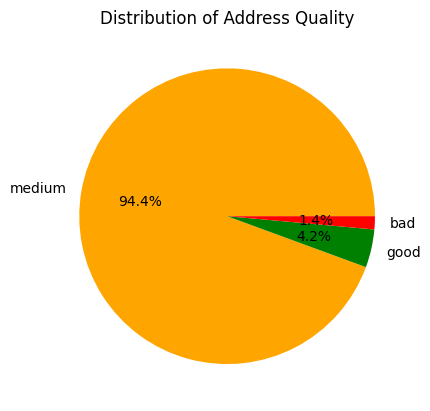

In [213]:
# Pie Chart
validated_df['address_quality'].value_counts().plot.pie(autopct='%1.1f%%', colors=['orange', 'green', 'red'])
plt.title('Distribution of Address Quality')
plt.ylabel('')
plt.show()


##  Address Quality in each State:

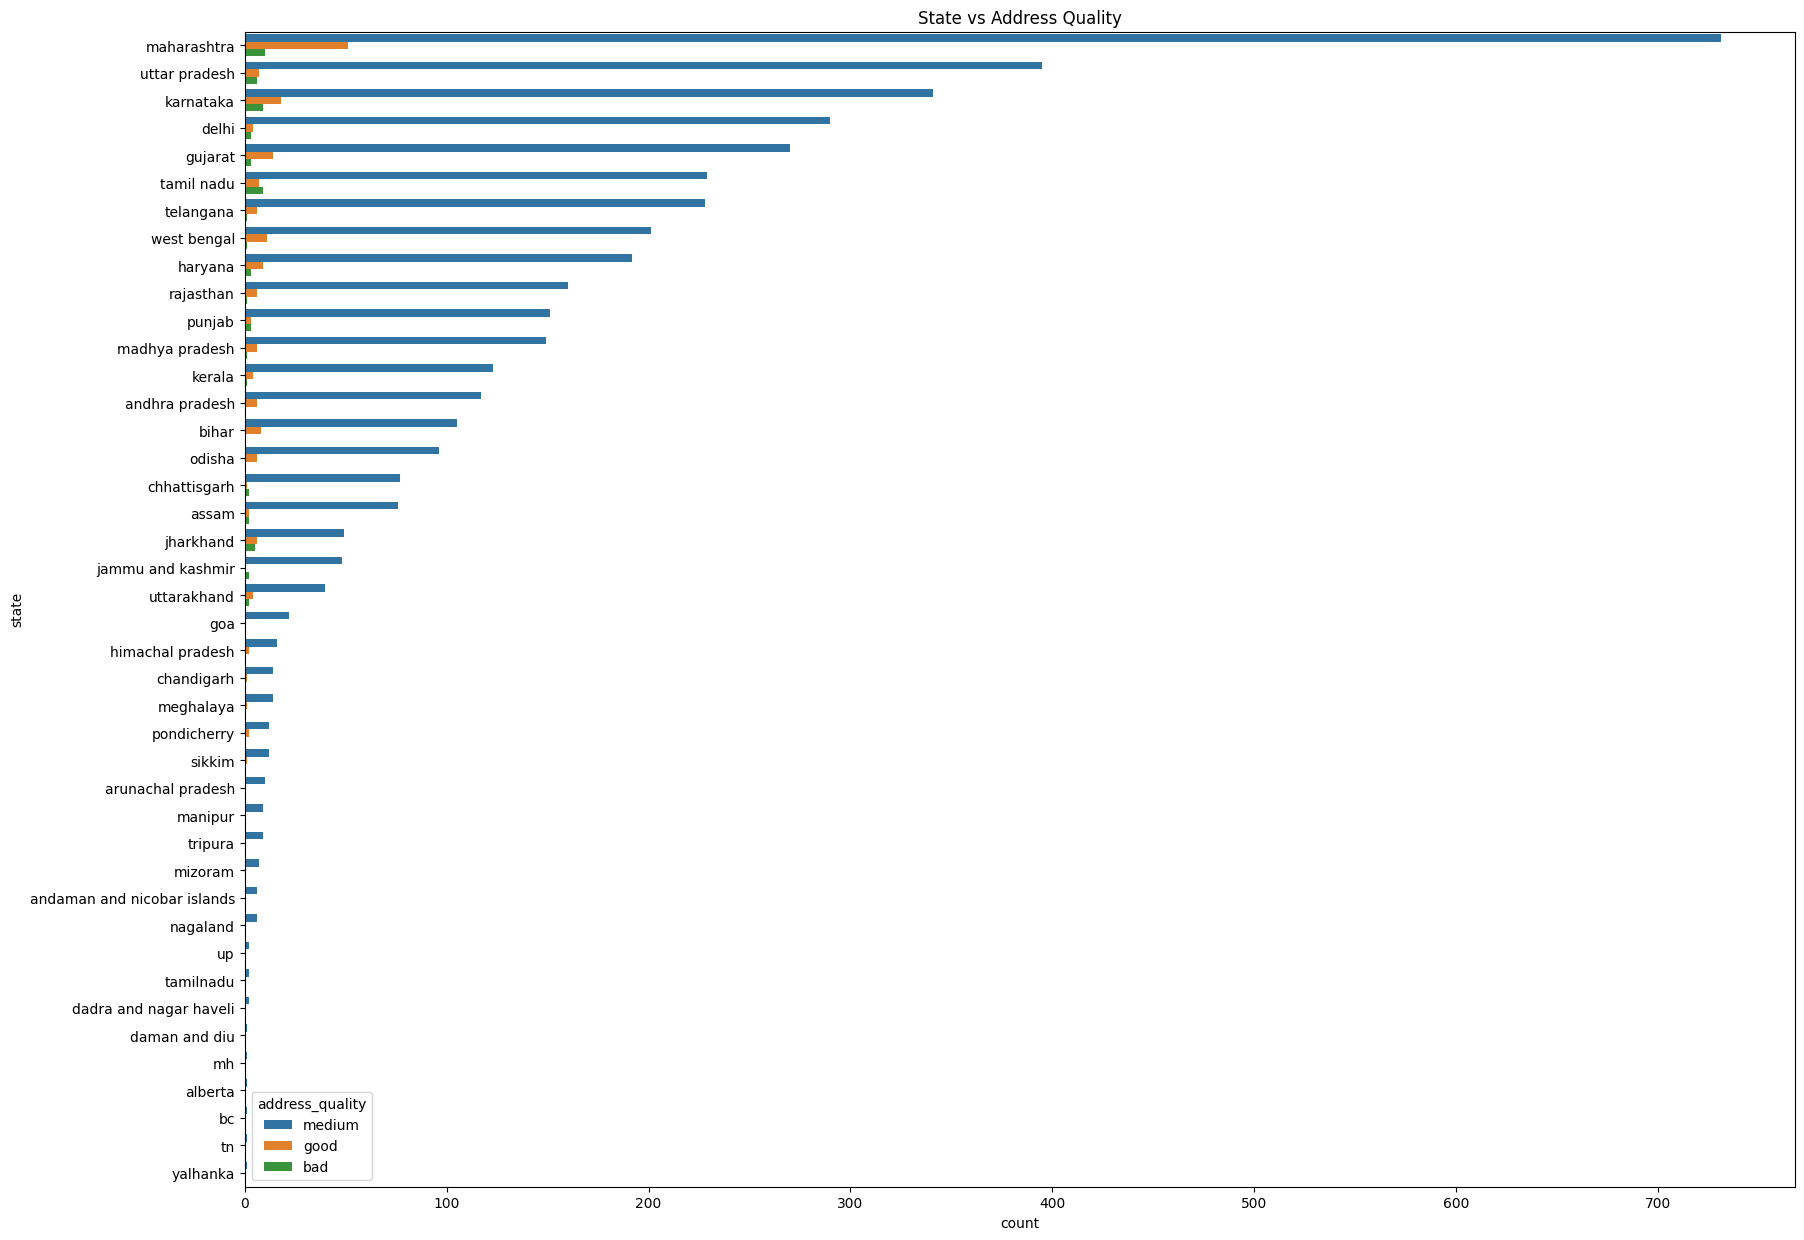

In [211]:
# Bar Plot
plt.figure(figsize=(20, 15))
sns.countplot(y='state', hue='address_quality', data=validated_df, order=validated_df['state'].value_counts().index)
plt.title('State vs Address Quality')
plt.show()


In [225]:
validated_df.to_csv("./static/enhanced_address_dataset_final", index=False)

## **4. Classification Model:**
**Building a classification model to categorize the addresses based on the below criteria:**
- **Good**: Address is complete, valid.
- **Medium**: Address is mostly complete, may have minor validation issues.
- **Bad**: Address is incomplete, invalid.


In [214]:
# Preparing the features
X = validated_df.drop(['address_quality', 'address_completeness', 'address_validity'], axis=1)
y = validated_df['address_quality']

# Handling categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Handling missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Converting imputed array back to DataFrame to retain column names
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Training a GradientBoosting model to determine feature importance
model = GradientBoostingClassifier(random_state=42)
model.fit(X_imputed_df, y)

GradientBoostingClassifier(random_state=42)

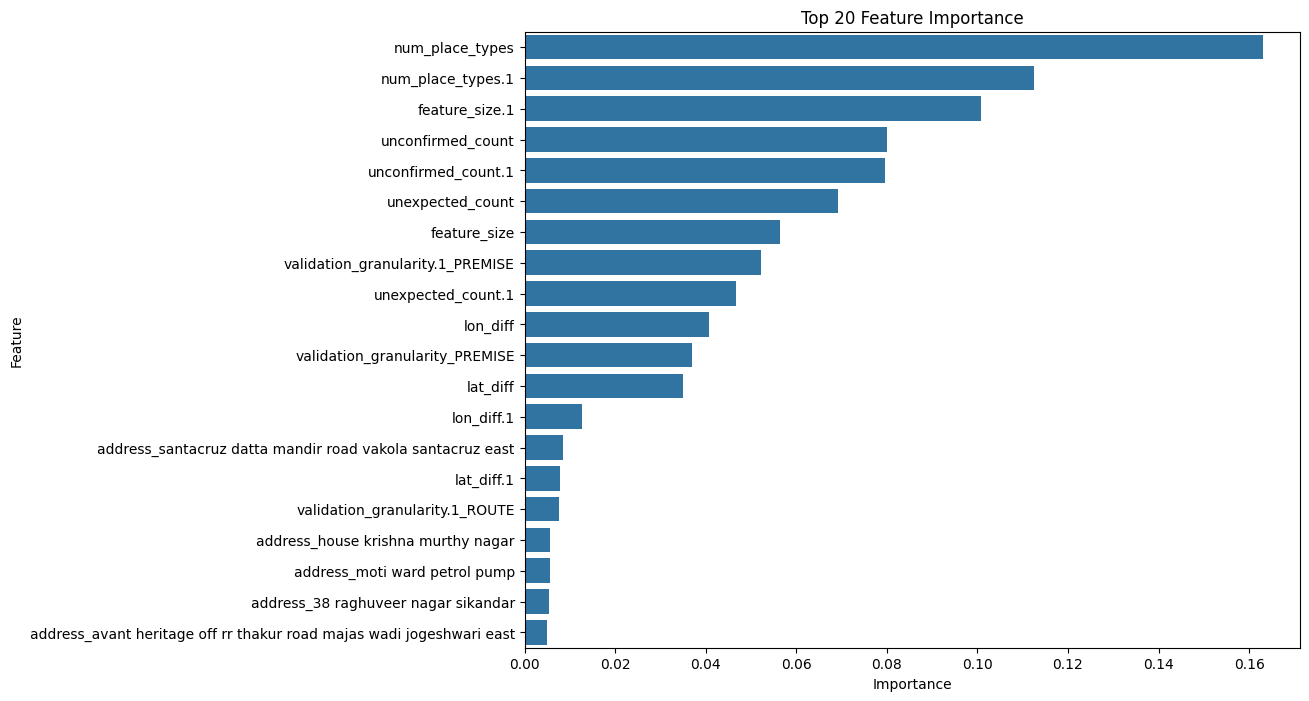

In [215]:
# Plot feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top 20 features
top_n = 20
top_indices = indices[:top_n]
top_features = X_imputed_df.columns[top_indices]
top_importances = importances[top_indices]

# Plot top 20 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances, y=top_features)
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [216]:
# Include only top important features
X_important = X_imputed_df[top_features]

# Stratified split to maintain the distribution of classes
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, stratify=y, random_state=42)


In [219]:
# Creating a pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Using GridSearchCV to find the best hyperparameters
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   2.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   2.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   2.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   2.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100; total time=   2.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200; total time=   4.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200; total time=   4.6s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=200; total time=   4.5s
[CV] END classifier

In [220]:
# Evaluate the model
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


              precision    recall  f1-score   support

         bad       0.77      0.77      0.77        13
        good       0.97      0.97      0.97        37
      medium       1.00      1.00      1.00       844

    accuracy                           0.99       894
   macro avg       0.91      0.91      0.91       894
weighted avg       0.99      0.99      0.99       894

Accuracy: 0.9910514541387024


### Data Augmentation:
As the dataset is small, so we are applying some data augmentation techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.

In [221]:
# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Re-train the model with the augmented data
best_model.fit(X_train_res, y_train_res)

# Evaluate the model again
y_pred_res = best_model.predict(X_test)
print(classification_report(y_test, y_pred_res))
print(f"Accuracy after SMOTE: {accuracy_score(y_test, y_pred_res)}")


              precision    recall  f1-score   support

         bad       0.87      1.00      0.93        13
        good       1.00      0.97      0.99        37
      medium       1.00      1.00      1.00       844

    accuracy                           1.00       894
   macro avg       0.96      0.99      0.97       894
weighted avg       1.00      1.00      1.00       894

Accuracy after SMOTE: 0.9966442953020134


In [222]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_res)
print(conf_matrix)


[[ 13   0   0]
 [  0  36   1]
 [  2   0 842]]


In [223]:
# Save the model
model_path = './model/address_quality_model_gradient_boosting.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Save the columns used in the model
X_columns_path = './model/X_columns_gradient_boosting.pkl'
with open(X_columns_path, 'wb') as f:
    pickle.dump(X_important.columns, f)

# Save the label encoder
label_encoder_path = './model/label_encoder_gradient_boosting.pkl'
label_encoder = LabelEncoder()
label_encoder.fit(y)
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

print("Model, columns, and label encoder saved successfully.")


Model, columns, and label encoder saved successfully.
